## Table of Contents

### 1. Use a trained Autoencoder model to extract features from the images
> #### 1.1 Prepare data
> #### 1.2 Create autoencoder model and train it
> #### 1.3 Extract features from images using the trained encoder
### 2. Cluster images on the basis of extracted features
> #### 2.1 Prepare clustering algorithm
> #### 2.2 Get clusters from the features
> #### 2.3 Visualize results

### 1. Use a trained Autoencoder model to extract features from the images

#### 1.1 Prepare data

In [1]:
# Upload data from Google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/CNN_RNN_SIT/MNIST.zip

Streaming output truncated to the last 5000 lines.
  inflating: MNIST/images/10034.png  
  inflating: MNIST/images/10054.png  
  inflating: MNIST/images/10146.png  
  inflating: MNIST/images/10149.png  
  inflating: MNIST/images/10156.png  
  inflating: MNIST/images/10171.png  
  inflating: MNIST/images/10188.png  
  inflating: MNIST/images/1019.png   
  inflating: MNIST/images/10206.png  
  inflating: MNIST/images/10238.png  
  inflating: MNIST/images/10279.png  
  inflating: MNIST/images/10295.png  
  inflating: MNIST/images/10359.png  
  inflating: MNIST/images/10401.png  
  inflating: MNIST/images/10426.png  
  inflating: MNIST/images/10527.png  
  inflating: MNIST/images/10543.png  
  inflating: MNIST/images/10553.png  
  inflating: MNIST/images/10572.png  
  inflating: MNIST/images/10778.png  
  inflating: MNIST/images/10805.png  
  inflating: MNIST/images/10826.png  
  inflating: MNIST/images/10829.png  
  inflating: MNIST/images/10859.png  
  inflating: MNIST/images/1086.png   

In [3]:
# import libraries and modules

%matplotlib inline

import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Input, Conv2D

from skimage.io import imread

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

In [4]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [5]:
# define directory path
data_dir = os.path.join(os.path.abspath('.'), 'MNIST')

In [6]:
# read data files
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


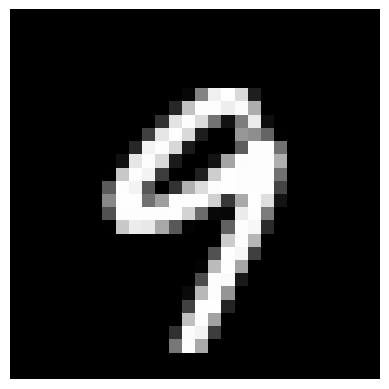

In [14]:
# plot sample image
## choose a random image
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'images', img_name)

## read image
img = imread(filepath, as_gray=True)

## show image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
# print shape of image
img.shape

(28, 28)

In [16]:
# read images and store them as numpy arrays

## read train images
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'images', img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)

## store them in train_x
train_x = np.stack(temp)
train_x = train_x.reshape(-1, 784).astype('float32')

In [17]:
# print shape of train_x array
train_x.shape

(49000, 784)

In [18]:
# print minimum and maximum values of train_x array
train_x.min(), train_x.max()

(0.0, 1.0)

In [19]:
# split data into training and validation
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]

#### 1.2 Create autoencoder model and train it

![alt text](https://drive.google.com/uc?id=1duzhaXwCuvZf4gs03pJNcJPEYUxT2y_8)

In [20]:
# define architecture of autoencoder

## this is our input placeholder
input_img = Input(shape=(784, ))

## "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(10, activation='linear')(encoded) #Bottleneck

## "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its features
encoder = Model(input_img, encoded)

In [21]:
# print summary of autoencoder
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2000)              1570000   
                                                                 
 dense_1 (Dense)             (None, 500)               1000500   
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 500)               50500 

In [22]:
# print summary of encoder
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2000)              1570000   
                                                                 
 dense_1 (Dense)             (None, 500)               1000500   
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 2621610 (10.00 MB)
Trainable params: 2621610 (10.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
# train autoencoder
train_history = autoencoder.fit(train_x, train_x, epochs=100, batch_size=256, validation_data=(val_x, val_x))

Epoch 1/100
134/134 [==============================] - 7s 11ms/step - loss: 0.0604 - val_loss: 0.0341
Epoch 2/100
134/134 [==============================] - 1s 10ms/step - loss: 0.0279 - val_loss: 0.0246
Epoch 3/100
134/134 [==============================] - 2s 12ms/step - loss: 0.0223 - val_loss: 0.0211
Epoch 4/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 5/100
134/134 [==============================] - 1s 8ms/step - loss: 0.0183 - val_loss: 0.0181
Epoch 6/100
134/134 [==============================] - 1s 8ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 7/100
134/134 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 8/100
134/134 [==============================] - 1s 7ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 9/100
134/134 [==============================] - 1s 8ms/step - loss: 0.0156 - val_loss: 0.0161
Epoch 10/100
134/134 [==============================] - 1s 10ms/step - loss: 0.0152 - v

1072/1072 [==============================] - 3s 3ms/step


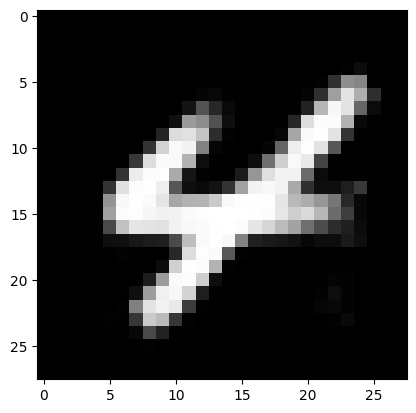

In [25]:
# check output of autoencoder model
temp = autoencoder.predict(train_x)
plt.imshow(temp[0].reshape((28, 28)), cmap='gray')

In [26]:
# check output of encoder model
temp = encoder.predict(train_x)
temp[0]

1072/1072 [==============================] - 2s 2ms/step


array([  9.054764 , -28.111315 ,  -5.442896 ,  -7.128633 ,   8.884175 ,
        12.427884 ,   2.5837593,   3.3454692,  -1.6886381, -17.951752 ],
      dtype=float32)

#### 1.3 Extract features from images using the trained encoder

In [27]:
# get features from encoder
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)


460/460 [==============================] - 1s 3ms/step


### 2. Cluster images on the basis of extracted features

#### 2.1 Prepare clustering algorithm

In [28]:
# train a kmeans clustering model to categorize the features of images

## define kmeans model
km = KMeans(n_clusters=10)

#### 2.2 Get clusters from the features


In [29]:
## train kmeans model on features extracted from training data
km.fit(pred_auto_train)

## get predictions from kmeans model on features extracted from validation data
pred = km.predict(pred_auto)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### 2.3 Visualize results

This image belongs to Cluster 4


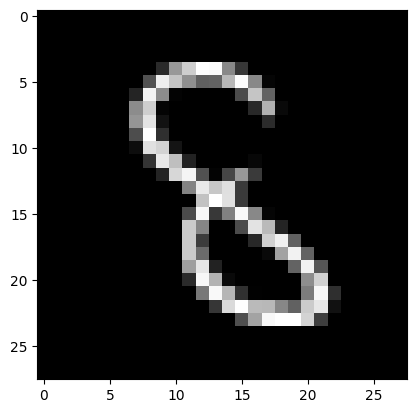

In [30]:
# check the output of kmeans model
index = rng.choice(range(len(val_x)))

print("This image belongs to Cluster " + str(pred[index]))
plt.imshow(val_x[index].reshape((28, 28)), cmap='gray')
plt.show()

In [31]:
# get actual classes
train_y = train.label.values
train_y, val_y = train_y[:split_size], train_y[split_size:]

# compare clusters with actual classes
temp = pd.DataFrame({"val_y":val_y, "cluster_name":pred})
temp[temp.cluster_name == 1].head()

,val_y,cluster_name
31,2,1
36,2,1
38,2,1
53,2,1
54,2,1


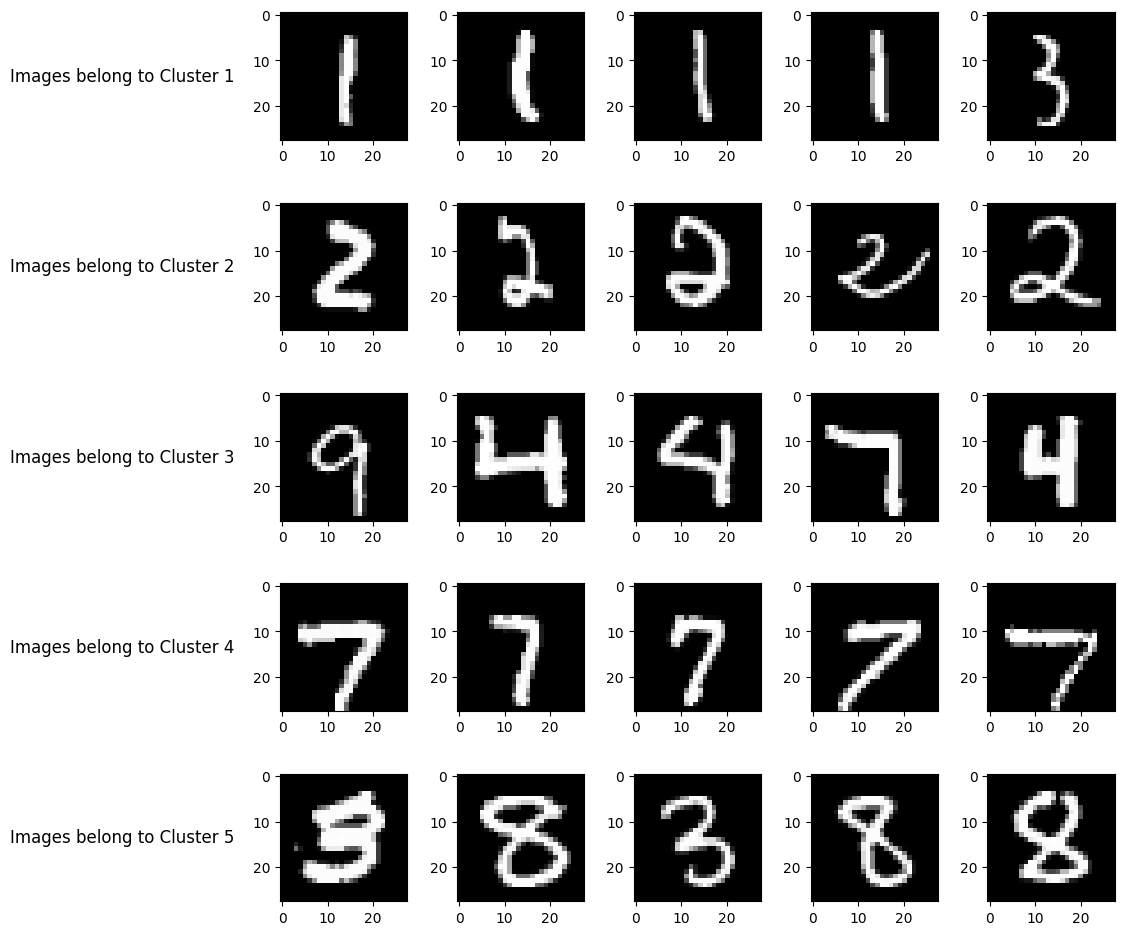

In [32]:
# visualize multiple images of cluster
## create plot
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10))


## set row name on the basis of clusters
rows = ['Images belong to Cluster {}'.format(row) for row in ['1', '2', '3', '4', '5']]
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

## set images in subplots
for i in range(5):
  temp2 = temp[temp.cluster_name == i].head()
  for j, img in enumerate(val_x[temp2.index.values]):
    img = img.reshape((28, 28))
    axes[i][j].imshow(img, cmap='gray')

## adjust plot with respect to the column title
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

## show plot
plt.show()

In [ ]:
# print score of overall model
normalized_mutual_info_score(pred, val_y)

0.6542624125587448